**Ερώτημα 1: Feedforward Neural Network**

*Βήμα 1: Φόρτωση δεδομένων (mfccs)*

In [15]:
# Libraries
from IPython.utils import tempdir
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import librosa
import torch
import librosa.display
import soundfile
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import tensorflow as tf
from torch.utils.data import DataLoader


# Drive
from google.colab import drive
drive.mount("/content/drive/")
path_test_X = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/test/mfccs/X.npy"
path_train_X = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/train/mfccs/X.npy"
path_val_X = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/val/mfccs/X.npy"
path_test_labels = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/test/mfccs/labels.npy"
path_train_labels = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/train/mfccs/labels.npy"
path_val_labels = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/val/mfccs/labels.npy"

def loadSound(path_X, path_labels):
  sound = np.load(path_X)
  path_labels = np.load(path_labels)
  count = range(len(path_labels))
  labels = []
  for tmp in count:
    if (path_labels[tmp] == "hiphop"):
        l=0
        labels.append(int(l))
    elif (path_labels[tmp] =="blues"):
        l=1
        labels.append(int(l))
    elif (path_labels[tmp] == "classical"):
        l=2
        labels.append(int(l))
    elif (path_labels[tmp] == "rock_metal_hardrock"):
        l=3
        labels.append(int(l))
  return sound, labels


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [16]:
test_X ,test_labels = loadSound(path_test_X, path_test_labels)
train_X ,train_labels = loadSound(path_train_X, path_train_labels)
val_X ,val_labels = loadSound(path_val_X, path_val_labels)

test = list(zip(test_X, test_labels))
train = list(zip(train_X, train_labels))
val = list(zip(val_X, val_labels))

test_dataloader = DataLoader(test,batch_size=16, shuffle=False) # Don't shuffle the test data
train_dataloader = DataLoader(train,batch_size=16, shuffle=True)
val_dataloader = DataLoader(val,batch_size=16, shuffle=True)

*Βήμα 2: Ορισμός Νευρωνικού Δικτύου*

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from torchvision import transforms

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential( nn.Linear(26, 128), nn.Linear(128, 32), nn.Linear(32, 4))

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

*Βήμα 3: Ορισμός διαδικασίας εκπαίδευσης*

In [3]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):

        # GPU - dont forget to move the data there
        X = X.to(device)
        y = y.to(device)
        X = X.type(torch.FloatTensor)

        # Compute prediction and loss
        pred = model(X) # For each input batch
        loss = loss_fn(pred, y) #compute loss

        # Backpropagation
        optimizer.zero_grad() #find gradients
        loss.backward()  #bacvk propagate loss
        optimizer.step() #optimization

        # per 100 batches report the value of the loss function on the training set
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


*Βήμα 4: Ορισμός διαδικασίας αξιολόγησης*

In [4]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    target=[]
    pred2 = []

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            pred = model(X.float())
            pred2.append(pred.argmax(1))
            test_loss += loss_fn(pred, y).item()
            target.append(y)

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    target = torch.cat(target)
    pred2 = torch.cat(pred2)
    f1 = f1_score(target, pred2, average = 'macro')
    conf = confusion_matrix(target, pred2)

    print(f"Test Error: \n Avg loss: {test_loss:>8f} %, f1 macro score: {f1}%, Accuracy: {(100*correct):>0.1f}%, \n Confusion matrix: \n{conf}\n")

    return f1

*Βήμα 5: Εκπαίδευση δικτύου*

In [10]:
device = 'cpu'
model = NeuralNetwork().to(device)  #assing model to device

# define the hyperparameters of the optimization/training process
learning_rate = 0.002
num_epochs = 30
batch_size = 16
loss_fn = nn.CrossEntropyLoss()

# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) ## Stochastic Gradient Descent
print(f"using cpu\n")
for t in range(num_epochs):
    print(f"Epoch {t+1}\n")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

using cpu

Epoch 1

loss: 1.481374  [    0/ 3200]
loss: 1.434547  [ 1600/ 3200]
Test Error: 
 Avg loss: 0.085718 %, f1 macro score: 0.1910520181664201%, Accuracy: 27.9%, 
 Confusion matrix: 
[[252 103   0   1]
 [180 123   0  21]
 [ 42 255   0   0]
 [285 105   0   9]]

Epoch 2

loss: 1.357808  [    0/ 3200]
loss: 1.396901  [ 1600/ 3200]
Test Error: 
 Avg loss: 0.084593 %, f1 macro score: 0.27925825772015334%, Accuracy: 40.4%, 
 Confusion matrix: 
[[  1   3 244 108]
 [  0   6 161 157]
 [  0  11 280   6]
 [  0   0 130 269]]

Epoch 3

loss: 1.379654  [    0/ 3200]
loss: 1.378405  [ 1600/ 3200]
Test Error: 
 Avg loss: 0.083317 %, f1 macro score: 0.3373045890471627%, Accuracy: 43.9%, 
 Confusion matrix: 
[[ 51   0 219  86]
 [  9   0 164 151]
 [  0   0 291   6]
 [  9   0 128 262]]

Epoch 4

loss: 1.251375  [    0/ 3200]
loss: 1.286829  [ 1600/ 3200]
Test Error: 
 Avg loss: 0.082663 %, f1 macro score: 0.15640612616237004%, Accuracy: 26.2%, 
 Confusion matrix: 
[[  2 344   0  10]
 [  0 301   0 

*Βήμα 6: Εκπαίδευση δικτύου με GPU*

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from torchvision import transforms

test_X ,test_labels = loadSound(path_test_X, path_test_labels)
train_X ,train_labels = loadSound(path_train_X, path_train_labels)
val_X ,val_labels = loadSound(path_val_X, path_val_labels)

test = list(zip(test_X, test_labels))
train = list(zip(train_X, train_labels))
val = list(zip(val_X, val_labels))

test_dataloader = DataLoader(test,batch_size=16, shuffle=False)
train_dataloader = DataLoader(train,batch_size=16, shuffle=True)
val_dataloader = DataLoader(val,batch_size=16, shuffle=True)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential( nn.Linear(26, 128), nn.Linear(128, 32), nn.Linear(32, 4))

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):

        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)
        X = X.type(torch.FloatTensor)

        # Compute prediction and loss
        pred = model(X.cuda())
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad() ##find gradients
        loss.backward()  ##bacvk propagate loss
        optimizer.step() ##optimization

        # per 100 batches report the value of the loss function on the training set
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    target=[]
    pred2 = []

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            pred = model(X.float())
            pred2.append(pred.argmax(1))
            test_loss += loss_fn(pred, y).item()
            target.append(y)

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    target = torch.cat(target)
    pred2 = torch.cat(pred2)
    pred2=pred2.cpu()
    target=target.cpu()

    f1 = f1_score(target, pred2, average = 'macro')
    conf = confusion_matrix(target, pred2)

    print(f"Test Error: \n Avg loss: {test_loss:>8f} %, f1 macro score: {f1}%, Accuracy: {(100*correct):>0.1f}%, \n Confusion matrix: \n{conf}\n")

    return f1


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = NeuralNetwork().to(device)  #assing model to device

# Define the hyperparameters of the optimization/training process
learning_rate = 0.002
num_epochs = 30
batch_size = 16
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) ## Stochastic Gradient Descent

if device == 'cuda':
  print('cuda')
else:
  print('cpu')

for t in range(num_epochs):
    print(f"Epoch {t+1}\n")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

cuda
Epoch 1

loss: 1.684015  [    0/ 3200]
loss: 1.365852  [ 1600/ 3200]
Test Error: 
 Avg loss: 0.087102 %, f1 macro score: 0.13277870461337568%, Accuracy: 20.0%, 
 Confusion matrix: 
[[190 166   0   0]
 [242  82   0   0]
 [156 138   3   0]
 [370  29   0   0]]

Epoch 2

loss: 1.438995  [    0/ 3200]
loss: 1.414457  [ 1600/ 3200]
Test Error: 
 Avg loss: 0.085249 %, f1 macro score: 0.36914564305860387%, Accuracy: 42.6%, 
 Confusion matrix: 
[[170  30  93  63]
 [ 57   9 170  88]
 [ 14   7 268   8]
 [122   3 135 139]]

Epoch 3

loss: 1.350741  [    0/ 3200]
loss: 1.360584  [ 1600/ 3200]
Test Error: 
 Avg loss: 0.085514 %, f1 macro score: 0.2279877465291294%, Accuracy: 32.2%, 
 Confusion matrix: 
[[  0 316  40   0]
 [  0 185 139   0]
 [  0  39 258   0]
 [  0 237 162   0]]

Epoch 4

loss: 1.328479  [    0/ 3200]
loss: 1.330988  [ 1600/ 3200]
Test Error: 
 Avg loss: 0.082165 %, f1 macro score: 0.4208824052471265%, Accuracy: 48.9%, 
 Confusion matrix: 
[[327  12   2  15]
 [218   9   2  95]
 

*Βήμα 7: Επιλογή μοντέλου*

In [18]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from torchvision import transforms

device = 'cpu'
model = NeuralNetwork().to(device)

# define the hyperparameters of the optimization/training process
learning_rate = 0.002
num_epochs = 30
batch_size = 16
loss_fn = nn.CrossEntropyLoss()

# define the optimizer object
optimizer = optim.SGD(model.parameters(), lr = learning_rate) ## Stochastic Gradient Descent

print(f"CPU\n")

tmp=0
for t in range(num_epochs):
    print(f"Epoch {t+1}\n")

    train_loop(train_dataloader, model, loss_fn, optimizer)

    f1 = test_loop(val_dataloader, model, loss_fn)

    if f1>tmp:
      tmp=f1

print(tmp)

CPU

Epoch 1

loss: 1.533472  [    0/ 3200]
loss: 1.384912  [ 1600/ 3200]
Test Error: 
 Avg loss: 0.086357 %, f1 macro score: 0.1003216875655739%, Accuracy: 24.1%, 
 Confusion matrix: 
[[  0 200   0   0]
 [  0 192   0   8]
 [  0 188   0  12]
 [  0 199   0   1]]

Epoch 2

loss: 1.367380  [    0/ 3200]
loss: 1.387726  [ 1600/ 3200]
Test Error: 
 Avg loss: 0.085635 %, f1 macro score: 0.13385164755622703%, Accuracy: 26.4%, 
 Confusion matrix: 
[[  0  69 131   0]
 [  0  15 185   0]
 [  0   4 196   0]
 [  0  11 189   0]]

Epoch 3

loss: 1.359846  [    0/ 3200]
loss: 1.311334  [ 1600/ 3200]
Test Error: 
 Avg loss: 0.084103 %, f1 macro score: 0.34583141806481266%, Accuracy: 38.1%, 
 Confusion matrix: 
[[ 92 108   0   0]
 [ 74 105  21   0]
 [ 51  41 108   0]
 [ 41 146  13   0]]

Epoch 4

loss: 1.387251  [    0/ 3200]
loss: 1.372712  [ 1600/ 3200]
Test Error: 
 Avg loss: 0.083398 %, f1 macro score: 0.2973075368761366%, Accuracy: 41.8%, 
 Confusion matrix: 
[[196   0   4   0]
 [172   0  28   0]
 

Το νευρωνικό δίκτυο είναι πιο γρήγορο ΄όταν χρησιμοποιείται η CPU αντι για GPU.

**[Ερώτημα 2: Convolutional Neural Network]**

*Βήμα 1: Φόρτωση δεδομένων (spectrograms)*

In [19]:
# Libraries
from IPython.utils import tempdir
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import librosa
import torch
import librosa.display
import soundfile
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import tensorflow as tf
from torch.utils.data import DataLoader

# Drive
from google.colab import drive
drive.mount("/content/drive/")
path_test_X = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/test/melgrams/X.npy"
path_train_X = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/train/melgrams/X.npy"
path_val_X = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/val/melgrams/X.npy"
path_test_labels = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/test/melgrams/labels.npy"
path_train_labels = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/train/melgrams/labels.npy"
path_val_labels = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/val/melgrams/labels.npy"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [20]:
def loadSound(path_X, path_labels):
  sound = []
  labels = []
  sound = np.load(path_X)
  path_labels=np.load(path_labels)
  count = range(len(path_labels))
  ch=0
  cb=0
  cc=0
  cr=0
  for tmp in count:
    if(path_labels[tmp] == 'hiphop'):
        l=0
        ch+=1
        labels.append(int(l))
    elif (path_labels[tmp] == 'blues'):
        l=1
        cb+=1
        labels.append(int(l))
    elif (path_labels[tmp] == 'classical'):
        l=2
        cc+=1
        labels.append(int(l))
    elif (path_labels[tmp] == 'rock_metal_hardrock'):
        l=3
        cr+=1
        labels.append(int(l))
  return sound, labels, ch, cb, cc, cr

In [21]:
test_X , test_labels, hte, bte, cte, rte = loadSound(path_test_X, path_test_labels)
train_X , train_labels, htr, btr, ctr, rtr = loadSound(path_train_X, path_train_labels)
val_X , val_labels, hval, bval, cval, rval = loadSound(path_val_X, path_val_labels)
test = list(zip(test_X, test_labels))
train = list(zip(train_X, train_labels))
val = list(zip(val_X, val_labels))

# Define the batch size.
batch_size = 16

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)

Blues


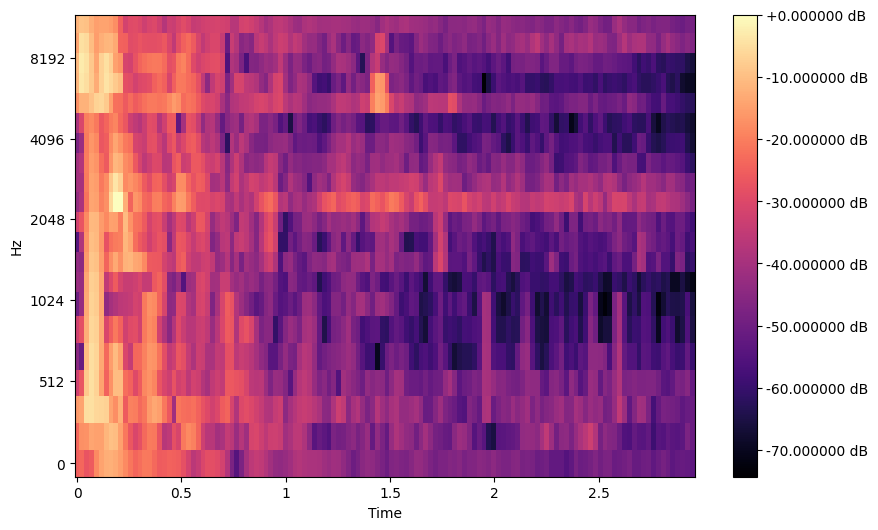

Classical


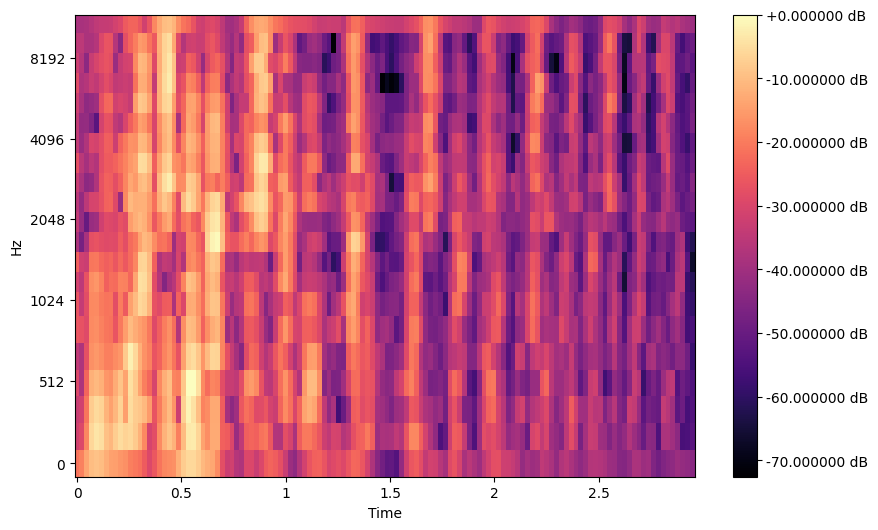

Hiphop


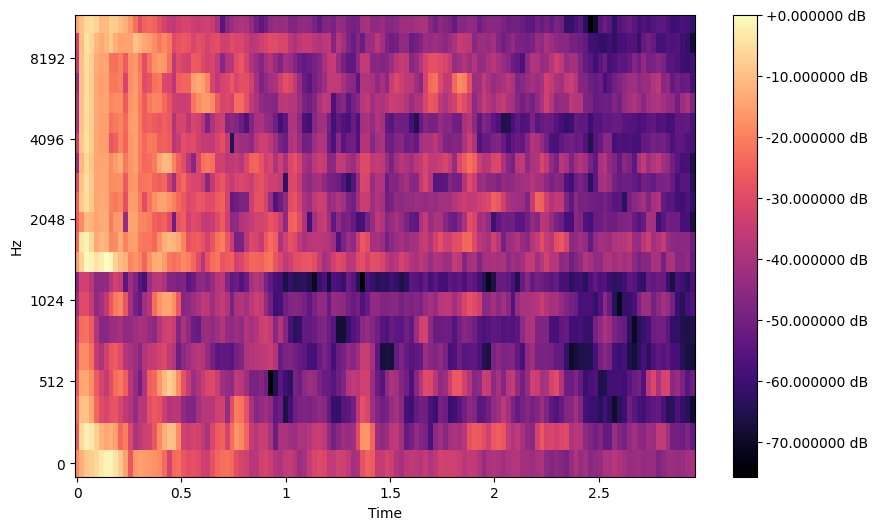

Rock metal hardrock


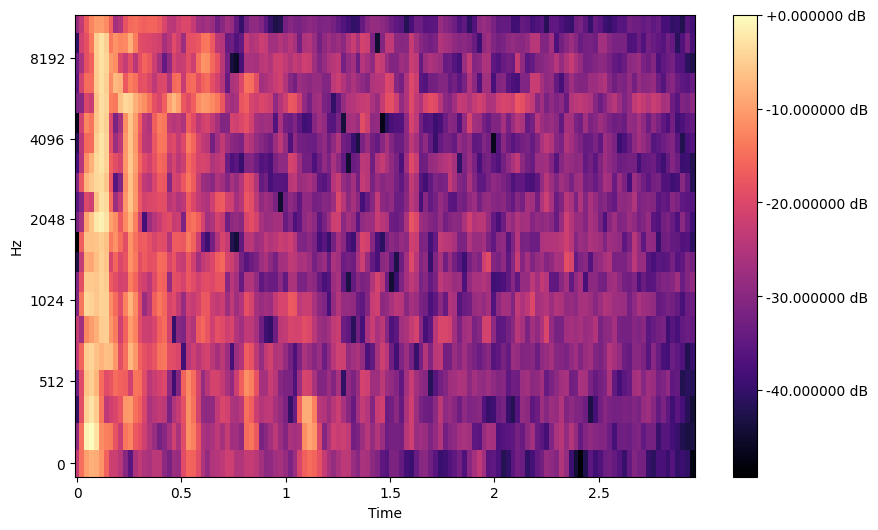

In [22]:
from IPython.display import Audio, display, Image, YouTubeVideo
import librosa.display
import random

# Visualize a melgram.
def visualize_melgram(data, name):
  hop_length = 512
  plt.figure(figsize=(10, 6));

  print(name)
  librosa.display.specshow( data, hop_length=hop_length, x_axis='time', y_axis='mel');
  plt.colorbar(format='%+2f dB');
  plt.show()

# Select a random integer.
r = random.randint(0, 2)

# Visualize a random melgram.
if r==0:
  b = random.randint(0, btr)
  c = random.randint(0, ctr)
  h = random.randint(0, htr)
  r = random.randint(0, rtr)
  temp = np.load(path_train_X)
  visualize_melgram(temp[b], "Blues")
  visualize_melgram(temp[btr + c], "Classical")
  visualize_melgram(temp[btr + ctr + h], "Hiphop")
  visualize_melgram(temp[btr + ctr + htr + r], "Rock metal hardrock")

elif r==1:
  b = random.randint(0, bte)
  c = random.randint(0, cte)
  h = random.randint(0, hte)
  r = random.randint(0, rte)
  temp = np.load(path_test_X)
  visualize_melgram(temp[b], "Blues")
  visualize_melgram(temp[bte + c], "Classical")
  visualize_melgram(temp[bte + cte + h], "Hiphop")
  visualize_melgram(temp[bte + cte + hte + r], "Rock metal hardrock")

elif r==2:
  b = random.randint(0, bval)
  c = random.randint(0, cval)
  h = random.randint(0, hval)
  r = random.randint(0, rval)
  temp = np.load(path_val_X)
  visualize_melgram(temp[b], "Blues")
  visualize_melgram(temp[bval + c], "Classical")
  visualize_melgram(temp[bval + cval + h], "Hiphop")
  visualize_melgram(temp[bval + cval + hval + r], "Rock metal hardrock")

*Βήμα 2: Ορισμός Νευρωνικού Δικτύου*

In [24]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import torchvision
import torchvision.transforms as transforms

class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, 5)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.conv3 = nn.Conv2d(32, 64, 5)
    self.conv4 = nn.Conv2d(64, 128, 5)
    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)

      x = x.view(x.size(0),-1)
      x = self.dense1(x)
      x = self.dense2(x)
      x = self.dense3(x)
      x = self.dense4(x)

      return x

*Βήμα 3: Εκπαίδευση δικτύου*

In [26]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):

        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # per 100 batches report the value of the loss function on the training set
        if batch % 100 == 0:
          loss, current = loss.item(), batch * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# The test loop does not need the optimizer, we just pass the data through the trained model and measure the error in predictions.
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    target = []
    pred2 = []
    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            pred2.append(pred.argmax(1))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            target.append(y)

    target = torch.cat(target)
    pred2 = torch.cat(pred2)
    test_loss /= size
    correct /= size
    f1 = f1_score(target, pred2, average = 'macro')
    conf = confusion_matrix(target, pred2)
    tmp = 100*correct
    print(f"Test Error: Avg loss: {test_loss:>8f} %, f1 macro score: {f1}%,\n Accuracy: {(100*correct):>0.1f}%,\n confusion matrix: {conf}\n")
    return f1, tmp


In [27]:
device = 'cpu'
net = LeNet().to(device)
learning_rate = 0.002
num_epochs = 30
batch_size = 16
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

for t in range(num_epochs):
    print(f"Epoch {t+1}\n")
    train_loop(train_loader, net, loss_fn, optimizer)
    test_loop(test_loader, net, loss_fn)


Epoch 1



RuntimeError: ignored

Cannot be trained.


*Βήμα 4: Pooling and padding*

In [28]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)
      x = F.max_pool2d(self.conv1(x), kernel_size=2)
      x = F.max_pool2d(self.conv2(x), kernel_size = 2)
      x = F.max_pool2d(self.conv3(x), kernel_size = 2)
      x = F.max_pool2d(self.conv4(x), kernel_size = 2)

      x = x.view(x.size(0), -1)

      x = self.dense1(x)
      x = self.dense2(x)
      x = self.dense3(x)
      x = self.dense4(x)

      return x

In [ ]:
device = 'cpu'
net = LeNet().to(device)

learning_rate = 0.002
num_epochs = 30
batch_size = 16
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

for t in range(num_epochs):
    print(f"Epoch {t+1}\n")
    train_loop(train_loader, net, loss_fn, optimizer)
    test_loop(test_loader, net, loss_fn)

Epoch 1

loss: 1.375723  [    0/ 3200]
loss: 1.005556  [ 1600/ 3200]
Test Error: Avg loss: 0.053629 %, f1 macro score: 0.6326439781236384%,
 Accuracy: 62.9%,
 confusion matrix: [[289  52   3  12]
 [ 70 168  15  71]
 [  2  19 261  15]
 [ 56 171  25 147]]

Epoch 2

loss: 0.891672  [    0/ 3200]
loss: 0.707690  [ 1600/ 3200]
Test Error: Avg loss: 0.053298 %, f1 macro score: 0.6434183372873961%,
 Accuracy: 63.0%,
 confusion matrix: [[287  57   3   9]
 [ 58 198   2  66]
 [ 13  83 189  12]
 [ 43 160   3 193]]

Epoch 3

loss: 0.677409  [    0/ 3200]
loss: 0.629948  [ 1600/ 3200]
Test Error: Avg loss: 0.043376 %, f1 macro score: 0.7284468719665224%,
 Accuracy: 71.9%,
 confusion matrix: [[273  67   4  12]
 [ 19 198  10  97]
 [  2  20 258  17]
 [ 26  98  15 260]]

Epoch 4

loss: 0.613675  [    0/ 3200]
loss: 0.374038  [ 1600/ 3200]
Test Error: Avg loss: 0.048679 %, f1 macro score: 0.6952591485769648%,
 Accuracy: 70.5%,
 confusion matrix: [[331  14   4   7]
 [ 99 121   6  98]
 [ 12  15 247  23]
 

 Με την προσθήκη του padding & pooling το νευρωνικό μπόρεσε να εκπαιδευτεί κατάλληλα και να πετύχει <70% ακρίβεια. Το f1 αυξάνεται τόσο αυξάνεται και το accuracy.

*Βήμα 5: Αλγόριθμοι βελτιστοποίησης*

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):

        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # per 100 batches report the value of the loss function on the training set
        if batch % 100 == 0:
          loss, current = loss.item(), batch * len(X)


# the test loop does not need the optimizer
# we just pass the data through the trained model and measure the error in predictions
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    target = []
    pred2 = []
    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            pred2.append(pred.argmax(1))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            target.append(y)

    target = torch.cat(target)
    pred2 = torch.cat(pred2)
    test_loss /= size
    correct /= size
    f1 = f1_score(target, pred2, average = 'macro')
    conf = confusion_matrix(target, pred2)
    tmp = 100*correct

    return f1, tmp

device = 'cpu'
net = LeNet().to(device)

learning_rate = 0.002
num_epochs = 30
batch_size = 16
loss_fn = nn.CrossEntropyLoss()

# define the optimizer
print("{:<20} {:<20} {:<20}".format('optimizer', 'macro f1', 'accuracy'))
for i in range(0,9):
  if i==0:
    optimizer = optim.AdamW(net.parameters(), lr = learning_rate)
    name="AdamW"
  elif i==1:
    optimizer = optim.ASGD(net.parameters(), lr = learning_rate)
    name="ASGD"
  elif i==2:
    optimizer = optim.Rprop(net.parameters(), lr = learning_rate)
    name="Rprop"
  elif i==3:
    optimizer = optim.RAdam(net.parameters(), lr = learning_rate)
    name="RAdam"
  elif i==4:
    optimizer = optim.SGD(net.parameters(), lr = learning_rate)
    name="SGD"
  elif i==5:
    optimizer = optim.NAdam(net.parameters(), lr = learning_rate)
    name="NAdam"
  elif i==6:
    optimizer = optim.Adagrad(net.parameters(), lr = learning_rate)
    name="Adagrad"
  elif i==7:
    optimizer = optim.Adadelta(net.parameters(), lr = learning_rate)
    name="Adadelta"
  elif i==8:
    optimizer = optim.RMSprop(net.parameters(), lr = learning_rate)
    name="RMSprop"

  for t in range(num_epochs):
      train_loop(train_loader, net, loss_fn, optimizer)
      f1, acc = test_loop(test_loader, net, loss_fn)

  print("{:<20} {:<20} {:<20}".format(name, f1, acc))


**[Ερώτημα 3: Improving Performance – προαιρετικό ερώτημα]**

*Βήμα 1: Reproducibility*

In [1]:
# Libraries
from IPython.utils import tempdir
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import librosa
import torch
import librosa.display
import soundfile
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import tensorflow as tf
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import torchvision
import torchvision.transforms as transforms
import random

# Drive
from google.colab import drive
drive.mount("/content/drive/")
path_test_X = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/test/melgrams/X.npy"
path_train_X = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/train/melgrams/X.npy"
path_val_X = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/val/melgrams/X.npy"
path_test_labels = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/test/melgrams/labels.npy"
path_train_labels = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/train/melgrams/labels.npy"
path_val_labels = "/content/drive/MyDrive/Colab Notebooks/ML/Assignments/music_genre_data_di/val/melgrams/labels.npy"

def loadSound(path_X, path_labels):
  sound = []
  labels = []
  sound = np.load(path_X)
  path_labels=np.load(path_labels)
  count = range(len(path_labels))
  ch=0
  cb=0
  cc=0
  cr=0
  for tmp in count:
    if(path_labels[tmp] == 'hiphop'):
        l=0
        ch+=1
        labels.append(int(l))
    elif (path_labels[tmp] == 'blues'):
        l=1
        cb+=1
        labels.append(int(l))
    elif (path_labels[tmp] == 'classical'):
        l=2
        cc+=1
        labels.append(int(l))
    elif (path_labels[tmp] == 'rock_metal_hardrock'):
        l=3
        cr+=1
        labels.append(int(l))
  return sound, labels, ch, cb, cc, cr

def torch_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

Mounted at /content/drive/


In [2]:
test_X , test_labels, hte, bte, cte, rte = loadSound(path_test_X, path_test_labels)
train_X , train_labels, htr, btr, ctr, rtr = loadSound(path_train_X, path_train_labels)
val_X , val_labels, hval, bval, cval, rval = loadSound(path_val_X, path_val_labels)
test = list(zip(test_X, test_labels))
train = list(zip(train_X, train_labels))
val = list(zip(val_X, val_labels))

batch_size = 16

test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)

In [7]:
def train_loop(reproducibility=True, n_run=2, device='cuda'):
    for n in range(n_run):
      print('run number: ', n+1)
      # set seed
      if reproducibility:
          torch_seed(seed=0)
      # model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)

      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:
              print('[%d, %5d] loss: %.4f' %(i+1, len(train_loader), loss_avg))

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    target = []
    pred2 = []
    # Dont accumulate gradients
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            pred2.append(pred.argmax(1))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            target.append(y)

    target = torch.cat(target)
    pred2 = torch.cat(pred2)
    test_loss /= size
    correct /= size
    pred2=pred2.cpu()
    target=target.cpu()
    f1 = f1_score(target, pred2, average = 'macro')
    conf = confusion_matrix(target, pred2)


    print(f"Error: loss: {test_loss:>8f} %, f1 macro score: {f1}%,\n Accuracy: {(100*correct):>0.1f}%,\n confusion matrix: \n{conf}\n")
    return f1, correct

In [9]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)
      x = F.max_pool2d(self.conv1(x), kernel_size=2)
      x = F.max_pool2d(self.conv2(x), kernel_size = 2)
      x = F.max_pool2d(self.conv3(x), kernel_size = 2)
      x = F.max_pool2d(self.conv4(x), kernel_size = 2)

      x = x.view(x.size(0),-1)
      x = self.dense1(x)
      x = self.dense2(x)
      x = self.dense3(x)
      x = self.dense4(x)

      return x

device = 'cuda'
net = LeNet().to(device)
learning_rate = 0.002
num_epochs = 30
batch_size = 16
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

for t in range(num_epochs):
  print(f"Epoch {t+1}\n")
  train_loop(reproducibility=True)
  test_loop(test_loader, net, loss_fn)

Epoch 1

run number:  1
[1,   200] loss: 1.4028
run number:  2
[1,   200] loss: 1.4028
Error: loss: 0.087843 %, f1 macro score: 0.09011582354705697%,
 Accuracy: 21.7%,
 confusion matrix: 
[[  0   0 355   1]
 [  0   0 324   0]
 [  0   0 297   0]
 [  0   0 398   1]]

Epoch 2

run number:  1
[1,   200] loss: 1.4028
run number:  2
[1,   200] loss: 1.4028
Error: loss: 0.087843 %, f1 macro score: 0.09011582354705697%,
 Accuracy: 21.7%,
 confusion matrix: 
[[  0   0 355   1]
 [  0   0 324   0]
 [  0   0 297   0]
 [  0   0 398   1]]

Epoch 3

run number:  1
[1,   200] loss: 1.4028
run number:  2
[1,   200] loss: 1.4028
Error: loss: 0.087843 %, f1 macro score: 0.09011582354705697%,
 Accuracy: 21.7%,
 confusion matrix: 
[[  0   0 355   1]
 [  0   0 324   0]
 [  0   0 297   0]
 [  0   0 398   1]]

Epoch 4

run number:  1
[1,   200] loss: 1.4028
run number:  2
[1,   200] loss: 1.4028
Error: loss: 0.087843 %, f1 macro score: 0.09011582354705697%,
 Accuracy: 21.7%,
 confusion matrix: 
[[  0   0 355 

*Βήμα 2: Activation functions*

In [10]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)
      x = self.conv1(x)
      x=F.relu(x)
      x=self.max_pool(x)
      x = self.conv2(x)
      x=F.relu(x)
      x=self.max_pool(x)
      x = self.conv3(x)
      x=F.relu(x)
      x=self.max_pool(x)
      x = self.conv4(x)
      x=F.relu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0),-1)
      x = self.dense1(x)
      x=F.relu(x)
      x = self.dense2(x)
      x=F.relu(x)
      x = self.dense3(x)
      x=F.relu(x)
      x = self.dense4(x)
      x=F.relu(x)
      return x

device = 'cuda'
net = LeNet().to(device)

learning_rate = 0.002
num_epochs = 30
batch_size = 16
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

print(f"ReLU")
for t in range(num_epochs):
    print(f"Epoch {t+1}\n")
    train_loop(reproducibility=True)
    f1_relu, acc_relu = test_loop(test_loader, net, loss_fn)

ReLU
Epoch 1

run number:  1
[1,   200] loss: 1.3924
run number:  2
[1,   200] loss: 1.3924
Error: loss: 0.086643 %, f1 macro score: 0.10277136258660509%,
 Accuracy: 25.9%,
 confusion matrix: 
[[356   0   0   0]
 [324   0   0   0]
 [297   0   0   0]
 [399   0   0   0]]

Epoch 2

run number:  1
[1,   200] loss: 1.3924
run number:  2
[1,   200] loss: 1.3924
Error: loss: 0.086643 %, f1 macro score: 0.10277136258660509%,
 Accuracy: 25.9%,
 confusion matrix: 
[[356   0   0   0]
 [324   0   0   0]
 [297   0   0   0]
 [399   0   0   0]]

Epoch 3

run number:  1
[1,   200] loss: 1.3924
run number:  2
[1,   200] loss: 1.3924
Error: loss: 0.086643 %, f1 macro score: 0.10277136258660509%,
 Accuracy: 25.9%,
 confusion matrix: 
[[356   0   0   0]
 [324   0   0   0]
 [297   0   0   0]
 [399   0   0   0]]

Epoch 4

run number:  1
[1,   200] loss: 1.3924
run number:  2
[1,   200] loss: 1.3924
Error: loss: 0.086643 %, f1 macro score: 0.10277136258660509%,
 Accuracy: 25.9%,
 confusion matrix: 
[[356   0

In [11]:
class LeNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)
      x = self.conv1(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv2(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv3(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv4(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = x.view(x.size(0),-1)
      x = self.dense1(x)
      x=F.elu(x)
      x = self.dense2(x)
      x=F.elu(x)
      x = self.dense3(x)
      x=F.elu(x)
      x = self.dense4(x)
      x=F.elu(x)
      return x

device = 'cuda'
net = LeNet().to(device)
learning_rate = 0.002
num_epochs = 30
batch_size = 16
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

print(f"ELU")
for t in range(num_epochs):

    print(f"Epoch {t+1}\n")

    train_loop(reproducibility=True)
    f1_elu, acc_elu = test_loop(test_loader, net, loss_fn)

ELU
Epoch 1

run number:  1
[1,   200] loss: 1.4037
run number:  2
[1,   200] loss: 1.4037
Error: loss: 0.087099 %, f1 macro score: 0.08876270173341302%,
 Accuracy: 21.6%,
 confusion matrix: 
[[  0   0 356   0]
 [  0   0 324   0]
 [  0   0 297   0]
 [  0   0 399   0]]

Epoch 2

run number:  1
[1,   200] loss: 1.4037
run number:  2
[1,   200] loss: 1.4037
Error: loss: 0.087099 %, f1 macro score: 0.08876270173341302%,
 Accuracy: 21.6%,
 confusion matrix: 
[[  0   0 356   0]
 [  0   0 324   0]
 [  0   0 297   0]
 [  0   0 399   0]]

Epoch 3

run number:  1
[1,   200] loss: 1.4037
run number:  2
[1,   200] loss: 1.4037
Error: loss: 0.087099 %, f1 macro score: 0.08876270173341302%,
 Accuracy: 21.6%,
 confusion matrix: 
[[  0   0 356   0]
 [  0   0 324   0]
 [  0   0 297   0]
 [  0   0 399   0]]

Epoch 4

run number:  1
[1,   200] loss: 1.4037
run number:  2
[1,   200] loss: 1.4037
Error: loss: 0.087099 %, f1 macro score: 0.08876270173341302%,
 Accuracy: 21.6%,
 confusion matrix: 
[[  0   0 

In [14]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)
      x = self.conv1(x)
      x=F.mish(x)
      x=self.max_pool(x)
      x = self.conv2(x)
      x=F.mish(x)
      x=self.max_pool(x)
      x = self.conv3(x)
      x=F.mish(x)
      x=self.max_pool(x)
      x = self.conv4(x)
      x=F.mish(x)
      x=self.max_pool(x)

      x = x.view(x.size(0),-1)

      x = self.dense1(x)
      x=F.mish(x)
      x = self.dense2(x)
      x=F.mish(x)
      x = self.dense3(x)
      x=F.mish(x)
      x = self.dense4(x)
      x=F.mish(x)
      return x

device = 'cuda'
net = LeNet().to(device)
learning_rate = 0.002
num_epochs = 30
batch_size = 16
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

print(f"Mish")

for t in range(num_epochs):

    print(f"Epoch {t+1}\n")

    train_loop(reproducibility=True)
    f1m, accm=test_loop(test_loader, net, loss_fn)


Mish
Epoch 1

run number:  1
[1,   200] loss: 1.3958
run number:  2
[1,   200] loss: 1.3958
Error: loss: 0.086722 %, f1 macro score: 0.08876270173341302%,
 Accuracy: 21.6%,
 confusion matrix: 
[[  0   0 356   0]
 [  0   0 324   0]
 [  0   0 297   0]
 [  0   0 399   0]]

Epoch 2

run number:  1
[1,   200] loss: 1.3958
run number:  2
[1,   200] loss: 1.3958
Error: loss: 0.086722 %, f1 macro score: 0.08876270173341302%,
 Accuracy: 21.6%,
 confusion matrix: 
[[  0   0 356   0]
 [  0   0 324   0]
 [  0   0 297   0]
 [  0   0 399   0]]

Epoch 3

run number:  1
[1,   200] loss: 1.3958
run number:  2
[1,   200] loss: 1.3958
Error: loss: 0.086722 %, f1 macro score: 0.08876270173341302%,
 Accuracy: 21.6%,
 confusion matrix: 
[[  0   0 356   0]
 [  0   0 324   0]
 [  0   0 297   0]
 [  0   0 399   0]]

Epoch 4

run number:  1
[1,   200] loss: 1.3958
run number:  2
[1,   200] loss: 1.3958
Error: loss: 0.086722 %, f1 macro score: 0.08876270173341302%,
 Accuracy: 21.6%,
 confusion matrix: 
[[  0   0

In [12]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)
      x = self.conv1(x)
      x=F.sigmoid(x)
      x=self.max_pool(x)
      x = self.conv2(x)
      x=F.sigmoid(x)
      x=self.max_pool(x)
      x = self.conv3(x)
      x=F.sigmoid(x)
      x=self.max_pool(x)
      x = self.conv4(x)
      x=F.sigmoid(x)
      x=self.max_pool(x)

      x = x.view(x.size(0),-1)

      x = self.dense1(x)
      x=F.sigmoid(x)
      x = self.dense2(x)
      x=F.sigmoid(x)
      x = self.dense3(x)
      x=F.sigmoid(x)
      x = self.dense4(x)
      x=F.sigmoid(x)

      return x

device = 'cuda'
net = LeNet().to(device)

learning_rate = 0.002
num_epochs = 30
batch_size = 16
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

print(f"Sigmoid")
for t in range(num_epochs):

    print(f"Epoch {t+1}\n")

    train_loop(reproducibility=True)
    f1s, accs = test_loop(test_loader, net, loss_fn)

Using Sigmoid
Epoch 1

run number:  1
[1,   200] loss: 1.3982
run number:  2
[1,   200] loss: 1.3982
Error: loss: 0.086553 %, f1 macro score: 0.09529411764705882%,
 Accuracy: 23.5%,
 confusion matrix: 
[[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 2

run number:  1
[1,   200] loss: 1.3982
run number:  2
[1,   200] loss: 1.3982
Error: loss: 0.086553 %, f1 macro score: 0.09529411764705882%,
 Accuracy: 23.5%,
 confusion matrix: 
[[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 3

run number:  1
[1,   200] loss: 1.3982
run number:  2
[1,   200] loss: 1.3982
Error: loss: 0.086553 %, f1 macro score: 0.09529411764705882%,
 Accuracy: 23.5%,
 confusion matrix: 
[[  0 356   0   0]
 [  0 324   0   0]
 [  0 297   0   0]
 [  0 399   0   0]]

Epoch 4

run number:  1
[1,   200] loss: 1.3982
run number:  2
[1,   200] loss: 1.3982
Error: loss: 0.086553 %, f1 macro score: 0.09529411764705882%,
 Accuracy: 23.5%,
 confusion matrix: 


In [15]:
print("{:20} {:20} {:20}".format('activation function', 'f1', 'accuracy'))

print("{:20} {:20} {:20}".format('ReLU', f1_relu, 100*acc_relu))
print("{:20} {:20} {:20}".format('ELU', f1_elu, 100*acc_elu))
print("{:20} {:20} {:20}".format('Mish', f1m, 100*accm))
print("{:20} {:20} {:20}".format('Sigmoid', f1s, 100*accs))

activation function  f1                   accuracy            
ReLU                  0.10277136258660509   25.872093023255815
ELU                   0.08876270173341302   21.584302325581394
Mish                  0.08876270173341302   21.584302325581394
Sigmoid               0.09529411764705882   23.546511627906977


*Βήμα 3: Learning rate scheduler*

In [16]:
from torch.optim import lr_scheduler

class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,16, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(16,32, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(32,64, kernel_size=5, padding=2)
    self.conv4 = nn.Conv2d(64,128, kernel_size=5, padding=2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)
      x = self.conv1(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv2(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv3(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv4(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = x.view(x.size(0),-1)
      x = self.dense1(x)
      x=F.elu(x)
      x = self.dense2(x)
      x=F.elu(x)
      x = self.dense3(x)
      x=F.elu(x)
      x = self.dense4(x)
      x=F.elu(x)

      return x
device = 'cuda'
net = LeNet().to(device)

learning_rate = 0.002
num_epochs = 30
batch_size = 16
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

scheduler1 = lr_scheduler.ExponentialLR(optimizer, verbose=True, gamma=0.9)
scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose=True)
scheduler3 = lr_scheduler.LinearLR(optimizer, verbose=True)
scheduler4 = lr_scheduler. StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)
scheduler5 = lr_scheduler.ConstantLR(optimizer, verbose=True)

print(f"Using ELU")

def train_loop(reproducibility=True,n_run=2,device='cuda'):

    for n in range(n_run):
      print('run number:', n+1)

      # seed
      if reproducibility:
          torch_seed(seed=0)

      # model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)

      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data

          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()

          if i%850==0:
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))

      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()

for t in range(num_epochs):

    print(f"Epoch {t+1}\n")

    train_loop(reproducibility=True)
    f1elu, accelu = test_loop(test_loader, net, loss_fn)

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
Using ELU
Epoch 1

run number: 1
[1,  200] loss: 1.4037


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
run number: 2
[1,  200] loss: 1.4037
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Error: loss: 0.087099 %, f1 macro score: 0.08876270173341302%,
 Accuracy: 21.6%,
 confusion matrix: 
[[  0   0 356   0]
 [  0   0 324   0]
 [  0   0 297   0]
 [  0   0 399   0]]

Epoch 2

run number: 1
[1,  200] loss: 1.4037
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 

*Βήμα 5: Batch Normalization*

In [17]:
from torch.optim import lr_scheduler

class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding =2)  ##in out kernel padding
    self.bn1 = torch.nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.bn2 = torch.nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.bn3 = torch.nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)
    self.bn4 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = self.bn1(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv2(x)
      x = self.bn2(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv3(x)
      x = self.bn3(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv4(x)
      x = self.bn4(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0), -1)

      x = self.dense1(x)
      x=F.elu(x)
      x = self.dense2(x)
      x=F.elu(x)
      x = self.dense3(x)
      x=F.elu(x)
      x = self.dense4(x)
      x=F.elu(x)

      return x

learning_rate = 0.002
num_epochs = 30
batch_size = 16
device = 'cuda'
net = LeNet().to(device)
scheduler1 = lr_scheduler.ExponentialLR(optimizer, verbose=True, gamma=0.9)
scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose=True)
scheduler3 = lr_scheduler.LinearLR(optimizer, verbose=True)
scheduler4 = lr_scheduler. StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)
scheduler5 = lr_scheduler.ConstantLR(optimizer, verbose=True)

print(f"ELU")
# define the corresponding loss function and the optim
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

def train_loop(reproducibility=True, n_run=2, device='cuda'):

    for n in range(n_run):
      print('run: ', n+1)

      # seed
      if reproducibility:
          torch_seed(seed=0)

      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()

for t in range(num_epochs):
    print(f"Epoch {t+1}\n")

    train_loop(reproducibility=True)
    f1elu, accelu = test_loop(test_loader, net, loss_fn)

Adjusting learning rate of group 0 to 3.5940e-09.
Adjusting learning rate of group 0 to 3.5940e-09.
Adjusting learning rate of group 0 to 1.1980e-09.
Adjusting learning rate of group 0 to 1.1980e-09.
Adjusting learning rate of group 0 to 3.9934e-10.
ELU
Epoch 1

run:  1
[1,  200] loss: 1.3794


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Adjusting learning rate of group 0 to 3.5940e-10.
Adjusting learning rate of group 0 to 3.5940e-10.
Adjusting learning rate of group 0 to 5.0316e-10.
Adjusting learning rate of group 0 to 5.0316e-10.
Adjusting learning rate of group 0 to 5.0316e-10.
run:  2
[1,  200] loss: 1.3794
Adjusting learning rate of group 0 to 4.5285e-10.
Adjusting learning rate of group 0 to 4.5285e-10.
Adjusting learning rate of group 0 to 5.8223e-10.
Adjusting learning rate of group 0 to 5.8223e-10.
Adjusting learning rate of group 0 to 5.8223e-10.
Error: loss: 0.087050 %, f1 macro score: 0.15285563365372323%,
 Accuracy: 22.6%,
 confusion matrix: 
[[193   5 158   0]
 [203   1 117   3]
 [179   1 117   0]
 [226   1 172   0]]

Epoch 2

run:  1
[1,  200] loss: 1.3794
Adjusting learning rate of group 0 to 5.2401e-10.
Adjusting learning rate of group 0 to 5.2401e-10.
Adjusting learning rate of group 0 to 6.4045e-10.
Adjusting learning rate of group 0 to 6.4045e-10.
Adjusting learning rate of group 0 to 6.4045e-10.


*Βήμα 6: Regularization*\
Αλλαγή του weight decay.

In [18]:
from torch.optim import lr_scheduler

class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
    self.bn1 = torch.nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
    self.bn2 = torch.nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.bn3 = torch.nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
    self.bn4 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = self.bn1(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv2(x)
      x = self.bn2(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv3(x)
      x = self.bn3(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = self.conv4(x)
      x = self.bn4(x)
      x=F.elu(x)

      x=self.max_pool(x)

      x = x.view(x.size(0), -1)

      x = self.dense1(x)
      x=F.elu(x)
      x = self.dense2(x)
      x=F.elu(x)
      x = self.dense3(x)
      x=F.elu(x)
      x = self.dense4(x)
      x=F.elu(x)

      return x


def train_loop(reproducibility=True, n_run=2, device='cuda'):

    for n in range(n_run):
      print('run: ', n+1)

      # seed
      if reproducibility:
          torch_seed(seed=0)

      #  model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)

      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))

      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()


def val_loop(reproducibility=True, n_run=2, device='cuda'):

    for n in range(n_run):
      print('run: ', n+1)

      # seed
      if reproducibility:
          torch_seed(seed=0)

      # model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)

      # training loop
      loss_avg = 0.0
      for i, data in enumerate(val_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:
              print('[%d, %4d] loss: %.4f' %(i+1, len(val_loader), loss_avg))

      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()

device = 'cuda'
net = LeNet().to(device)

learning_rate = 0.002
num_epochs = 60
batch_size = 16
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

scheduler1 = lr_scheduler.ExponentialLR(optimizer, verbose=True, gamma=0.9)
scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose=True)
scheduler3 = lr_scheduler.LinearLR(optimizer, verbose=True)
scheduler4 = lr_scheduler. StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)
scheduler5 = lr_scheduler.ConstantLR(optimizer, verbose=True)

print(f"ELU")

for t in range(num_epochs):
    print(f"Epoch {t+1}\n")

    train_loop(reproducibility=True)
    val_loop(reproducibility=True)
    test_loop(test_loader, net, loss_fn)

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
ELU
Epoch 1

run:  1
[1,  200] loss: 1.3794


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
run:  2
[1,  200] loss: 1.3794
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
run:  1
[1,   50] loss: 1.3635
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
run:  2
[1,   50] loss: 1.3635
Adjusting learning rate of group 0 to 3.2076e-04.
Adjusting learning rate of group 0 to 3.2076e-04.
Adjusting learning rate of group 0 to 3.7908e-04.
Adjusti

Αλλαγή μόνο του dropout στα linear layers.

In [19]:
from torch.optim import lr_scheduler

class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
    self.bn1 = torch.nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
    self.bn2 = torch.nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.bn3 = torch.nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
    self.bn4 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)
    self.dropout = nn.Dropout(0.5)


  def forward(self, x):
      x = torch.unsqueeze(x,1)
      x = self.conv1(x)
      x = self.bn1(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv3(x)
      x = self.bn3(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv4(x)
      x = self.bn4(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0),-1)

      x = self.dropout(x)
      x = self.dense1(x)
      x=F.elu(x)
      x = self.dropout(x)
      x = self.dense2(x)
      x=F.elu(x)
      x = self.dropout(x)
      x = self.dense3(x)
      x=F.elu(x)
      x = self.dropout(x)
      x = self.dense4(x)
      x=F.elu(x)

      return x

def train_loop(reproducibility=True, n_run=2, device='cuda'):

    for n in range(n_run):
      print('run: ', n+1)

      # seed
      if reproducibility:
          torch_seed(seed=0)

      # model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)

      # training
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))

      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()


def val_loop(reproducibility=True, n_run=2, device='cuda'):

    for n in range(n_run):
      print('run number: ', n+1)

      # seed
      if reproducibility:
          torch_seed(seed=0)

      # model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)

      # training loop
      loss_avg = 0.0
      for i, data in enumerate(val_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:
              print('[%d, %4d] loss: %.4f' %(i+1, len(val_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()

device = 'cuda'
net = LeNet().to(device)

learning_rate = 0.002
num_epochs = 60
batch_size = 16
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

scheduler1 = lr_scheduler.ExponentialLR(optimizer, verbose=True, gamma=0.9)
scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose=True)
scheduler3 = lr_scheduler.LinearLR(optimizer, verbose=True)
scheduler4 = lr_scheduler. StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)
scheduler5 = lr_scheduler.ConstantLR(optimizer, verbose=True)

print(f"ELU")

for t in range(num_epochs):
    print(f"Epoch {t+1}\n")

    train_loop(reproducibility=True)
    val_loop(reproducibility=True)
    test_loop(test_loader, net, loss_fn)

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
ELU
Epoch 1

run:  1
[1,  200] loss: 1.3795


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
run:  2
[1,  200] loss: 1.3795
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
run number:  1
[1,   50] loss: 1.4174
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
run number:  2
[1,   50] loss: 1.4174
Adjusting learning rate of group 0 to 3.2076e-04.
Adjusting learning rate of group 0 to 3.2076e-04.
Adjusting learning rate of group 0 to 3.790

In [20]:
from torch.optim import lr_scheduler


class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
    self.bn1 = torch.nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
    self.bn2 = torch.nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.bn3 = torch.nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
    self.bn4 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)
    self.dropout = nn.Dropout(0.5)


  def forward(self, x):
      x = torch.unsqueeze(x,1)
      x = self.conv1(x)
      x = self.bn1(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv3(x)
      x = self.bn3(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv4(x)
      x = self.bn4(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0),-1)

      x = self.dropout(x)
      x = self.dense1(x)
      x=F.elu(x)
      x = self.dropout(x)
      x = self.dense2(x)
      x=F.elu(x)
      x = self.dropout(x)
      x = self.dense3(x)
      x=F.elu(x)
      x = self.dropout(x)
      x = self.dense4(x)
      x=F.elu(x)

      return x


def train_loop(reproducibility=True, n_run=2, device='cuda'):

    for n in range(n_run):
      print('run: ', n+1)

      #  seed
      if reproducibility:
          torch_seed(seed=0)

      # model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)

      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()


def val_loop(reproducibility=True, n_run=2, device='cuda'):

    for n in range(n_run):
      print('run: ', n+1)

      # seed
      if reproducibility:
          torch_seed(seed=0)

      # model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)

      # training loop
      loss_avg = 0.0
      for i, data in enumerate(val_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:
              print('[%d, %4d] loss: %.4f' %(i+1, len(val_loader), loss_avg))

      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()

device = 'cuda'
net = LeNet().to(device)

learning_rate = 0.002
num_epochs = 60
batch_size = 16
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

scheduler1 = lr_scheduler.ExponentialLR(optimizer, verbose=True, gamma=0.9)
scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose=True)
scheduler3 = lr_scheduler.LinearLR(optimizer, verbose=True)
scheduler4 = lr_scheduler. StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)
scheduler5 = lr_scheduler.ConstantLR(optimizer, verbose=True)

print(f"ELU")

for t in range(num_epochs):
    print(f"Epoch {t+1}\n")

    train_loop(reproducibility=True)
    val_loop(reproducibility=True)
    test_loop(test_loader, net, loss_fn)

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
ELU
Epoch 1

run:  1
[1,  200] loss: 1.3795


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
Adjusting learning rate of group 0 to 2.8000e-04.
run:  2
[1,  200] loss: 1.3795
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 2.5200e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
Adjusting learning rate of group 0 to 3.2400e-04.
run:  1
[1,   50] loss: 1.4174
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 2.9160e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
Adjusting learning rate of group 0 to 3.5640e-04.
run:  2
[1,   50] loss: 1.4174
Adjusting learning rate of group 0 to 3.2076e-04.
Adjusting learning rate of group 0 to 3.2076e-04.
Adjusting learning rate of group 0 to 3.7908e-04.
Adjusti

*Βήμα 7: Training efficiency*\
**Batch size**

In [ ]:
from torch.optim import lr_scheduler
from time import process_time

class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
    self.bn1 = torch.nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding =2)
    self.bn2 = torch.nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding =2)
    self.bn3 = torch.nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding =2)
    self.bn4 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)
    self.dropout = nn.Dropout(0.5)


  def forward(self, x):
      x = torch.unsqueeze(x,1)
      x = self.conv1(x)
      x = self.bn1(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv3(x)
      x = self.bn3(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv4(x)
      x = self.bn4(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0),-1)

      x = self.dropout(x)
      x = self.dense1(x)
      x=F.elu(x)
      x = self.dropout(x)
      x = self.dense2(x)
      x=F.elu(x)
      x = self.dropout(x)
      x = self.dense3(x)
      x=F.elu(x)
      x = self.dropout(x)
      x = self.dense4(x)
      x=F.elu(x)

      return x


def train_loop(reproducibility=True, n_run=2, device='cuda'):

    for n in range(n_run):
      print('run: ', n+1)

      # seed
      if reproducibility:
          torch_seed(seed=0)

      # model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)

      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()


def val_loop(reproducibility=True, n_run=2, device='cuda'):

    for n in range(n_run):
      print('run: ', n+1)

      # seed
      if reproducibility:
          torch_seed(seed=0)
      # model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)
      # training loop
      loss_avg = 0.0
      for i, data in enumerate(val_loader):
          inputs, labels = data
          outputs = model(inputs.to(device))
          optimizer.zero_grad()
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) /(i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:
              print('[%d, %4d] loss: %.4f' %(i+1, len(val_loader), loss_avg))
      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()

device = 'cuda'
net = LeNet().to(device)

learning_rate = 0.002
num_epochs = 60
batch_size = 16
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

scheduler1 = lr_scheduler.ExponentialLR(optimizer, verbose=True, gamma=0.9)
scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose=True)
scheduler3 = lr_scheduler.LinearLR(optimizer, verbose=True)
scheduler4 = lr_scheduler. StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)
scheduler5 = lr_scheduler.ConstantLR(optimizer, verbose=True)

print(f"ELU")

for i in range (1, 8):
  batch_size=2**i
  train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
  test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
  val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)
  t0= process_time()
  for t in range(num_epochs):

      print(f"Epoch {t+1}\n")

      train_loop(reproducibility=True)
      val_loop(reproducibility=True)
      test_loop(test_loader, net, loss_fn)

  # training time
  t1 = process_time()-t0
  print(f"training time: {t1} \n")

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 2.2222e-04.
ELU
Epoch 1

run:  1
[1, 1600] loss: 1.5322
[851, 1600] loss: 1.4172


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Streaming output truncated to the last 5000 lines.
[[105  79 112  60]
 [123  59  94  48]
 [102  54  91  50]
 [116  87 111  85]]

Epoch 58

run:  1
[1,  400] loss: 1.4160
Adjusting learning rate of group 0 to 7.2272e-61.
Adjusting learning rate of group 0 to 7.2272e-61.
Adjusting learning rate of group 0 to 7.2272e-61.
Adjusting learning rate of group 0 to 7.2272e-61.
Adjusting learning rate of group 0 to 7.2272e-61.
run:  2
[1,  400] loss: 1.4160
Adjusting learning rate of group 0 to 6.5045e-61.
Adjusting learning rate of group 0 to 6.5045e-61.
Adjusting learning rate of group 0 to 6.5045e-61.
Adjusting learning rate of group 0 to 6.5045e-61.
Adjusting learning rate of group 0 to 6.5045e-61.
run:  1
[1,  100] loss: 1.3856
Adjusting learning rate of group 0 to 5.8540e-61.
Adjusting learning rate of group 0 to 5.8540e-61.
Adjusting learning rate of group 0 to 5.8540e-61.
Adjusting learning rate of group 0 to 5.8540e-61.
Adjusting learning rate of group 0 to 5.8540e-61.
run:  2
[1,  100] 

**Early stopping**

In [22]:
from torch.optim import lr_scheduler
from time import process_time

class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
    self.bn1 = torch.nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
    self.bn2 = torch.nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.bn3 = torch.nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
    self.bn4 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.dense1 = nn.Linear(1024, 1024)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)
    self.dropout = nn.Dropout(0.5)


  def forward(self, x):
      x = torch.unsqueeze(x,1)
      x = self.conv1(x)
      x = self.bn1(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv3(x)
      x = self.bn3(x)
      x=F.elu(x)
      x=self.max_pool(x)
      x = self.conv4(x)
      x = self.bn4(x)
      x=F.elu(x)
      x=self.max_pool(x)

      x = x.view(x.size(0),-1)

      x = self.dropout(x)
      x = self.dense1(x)
      x=F.elu(x)
      x = self.dropout(x)
      x = self.dense2(x)
      x=F.elu(x)
      x = self.dropout(x)
      x = self.dense3(x)
      x=F.elu(x)
      x = self.dropout(x)
      x = self.dense4(x)
      x=F.elu(x)
      return x


def train_loop(reproducibility=True, n_run=2, device='cuda'):

    # Early stopping
    last_loss = 100
    patience = 2
    triggertimes = 0

    for n in range(n_run):
      print('run: ', n+1)

      # seed
      if reproducibility:
          torch_seed(seed=0)

      # model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)

      # training loop
      loss_avg = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:
              print('[%d, %4d] loss: %.4f' %(i+1, len(train_loader), loss_avg))

      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()
      current_loss = val_loop(reproducibility=True)
      print('Current Loss:', current_loss)

      if current_loss > last_loss:
          trigger_times += 1
          print('Trigger times:', trigger_times)

          if trigger_times >= patience:
              print('Early stopping! \nStart to test process.')
              return model

      else:
          print('Trigger times: 0')
          trigger_times = 0

      last_loss = current_loss


def val_loop(reproducibility=True, n_run=2, device='cuda'):

    for n in range(n_run):
      print('run: ', n+1)

      # seed
      if reproducibility:
          torch_seed(seed=0)

      # model
      model = LeNet().to(device)
      loss_fn = nn.CrossEntropyLoss().to(device)
      optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.9)

      # training loop
      loss_avg = 0.0
      for i, data in enumerate(val_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs.to(device))
          loss = loss_fn(outputs, labels.to(device))
          loss_avg = (loss_avg * i + loss) / (i+1)
          loss.backward()
          optimizer.step()
          if i%850==0:
              print('[%d, %4d] loss: %.4f' %(i+1, len(val_loader), loss_avg))

      scheduler1.step()
      scheduler2.step()
      scheduler3.step()
      scheduler4.step()
      scheduler5.step()
      return loss

device = 'cuda'
net = LeNet().to(device)

learning_rate = 0.002
num_epochs = 60
batch_size = 16
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

scheduler1 = lr_scheduler.ExponentialLR(optimizer, verbose=True, gamma=0.9)
scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], verbose=True)
scheduler3 = lr_scheduler.LinearLR(optimizer, verbose=True)
scheduler4 = lr_scheduler. StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)
scheduler5 = lr_scheduler.ConstantLR(optimizer, verbose=True)

print(f"ELU")


for i in range (1, 8):
  batch_size=2**i
  train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
  test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
  val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)
  t0= process_time()
  for t in range(num_epochs):
      print(f"Epoch {t+1}\n")
      train_loop(reproducibility=True)
      test_loop(test_loader, net, loss_fn)

  # training time
  t1 = process_time()-t0
  print(f"Training time: {t1} s\n")


KeyboardInterrupt: ignored